In [1]:
# Import standard libraries
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Scikit-Learn stuff
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

# Keras
import tensorflow.keras as keras
import tensorflow as tf

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

In [2]:
core_path = os.getcwd()
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [3]:
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main Group"].to_list())
asteroids_y_bus = np.array(asteroids_df["Bus Class"].to_list())

In [4]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]
    y_train_bus, y_test_bus = asteroids_y_bus[train_index], asteroids_y_bus[test_index]

In [5]:
# Import the preprocessing module
from sklearn import preprocessing

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Scale the testing data ...
X_test_scaled = scaler.transform(X_test)

# And expanding the dimensionality for our ConvNet-based Autoencoder
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

In [6]:
# Get the number of inputs
n_inputs = asteroids_X.shape[1]

# Bottleneck size
n_bottleneck = 5

def create_model():
    
    # Input layer
    input_layer = keras.Input(shape=(n_inputs, 1))
    
    # --------------------
    # Encoder (Trial 14 params)
    # --------------------
    hidden_layer = keras.layers.Conv1D(
        filters=32,              # 1_filter
        kernel_size=6,           # 1_kernal
        activation="relu",
        padding="same"
    )(input_layer)

    hidden_layer = keras.layers.Conv1D(
        filters=128,             # 2_filter
        kernel_size=4,           # 2_kernal
        activation="relu",
        padding="same"
    )(hidden_layer)
    
    # Bottleneck
    bottleneck_lay = keras.layers.Flatten()(hidden_layer)
    bottleneck_lay = keras.layers.Dense(n_bottleneck, name="bottleneck")(bottleneck_lay)

    # --------------------
    # Decoder (mirror)
    # --------------------
    reset_lay = keras.layers.Dense(49 * 128)(bottleneck_lay)
    reshape_lay = keras.layers.Reshape((49, 128))(reset_lay)

    hidden_layer = keras.layers.Conv1DTranspose(
        filters=128,
        kernel_size=4,
        activation="relu",
        padding="same"
    )(reshape_lay)

    hidden_layer = keras.layers.Conv1DTranspose(
        filters=32,
        kernel_size=6,
        activation="relu",
        padding="same"
    )(hidden_layer)

    # Output layer
    output_layer = keras.layers.Conv1D(1, 1, padding="same")(hidden_layer)

    # Models
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    encoder_model = keras.models.Model(inputs=input_layer, outputs=bottleneck_lay)

    return model, encoder_model


# Build models
model, encoder_model = create_model()

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="mse"
)

# Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 49, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 49, 32)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 49, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 5)              │        31,365 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6272)           │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 49, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 49, 128)        │        65,664 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 49, 32)         │        24,608 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 49, 1)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,038 (687.65 KB)

 Trainable params: 176,038 (687.65 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
end_epoch = 500
batch_size = 32

# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=1,
                    validation_split=0.25,
                    callbacks=[es_callback])

Epoch 1/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.4899 - val_loss: 0.1361
Epoch 2/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0889 - val_loss: 0.0428
Epoch 3/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0401 - val_loss: 0.0333
Epoch 4/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0320 - val_loss: 0.0273
Epoch 5/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0312 - val_loss: 0.0255
Epoch 6/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0265 - val_loss: 0.0236
Epoch 7/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0229 - val_loss: 0.0190
Epoch 8/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0188 - val_loss: 0.0167
Epoch 9/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0158 - val_loss: 0.0151
Epoch 10/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0148 - val_loss: 0.0142
Epoch 11/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0138 - val_loss: 0.0134
Epoch 12/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

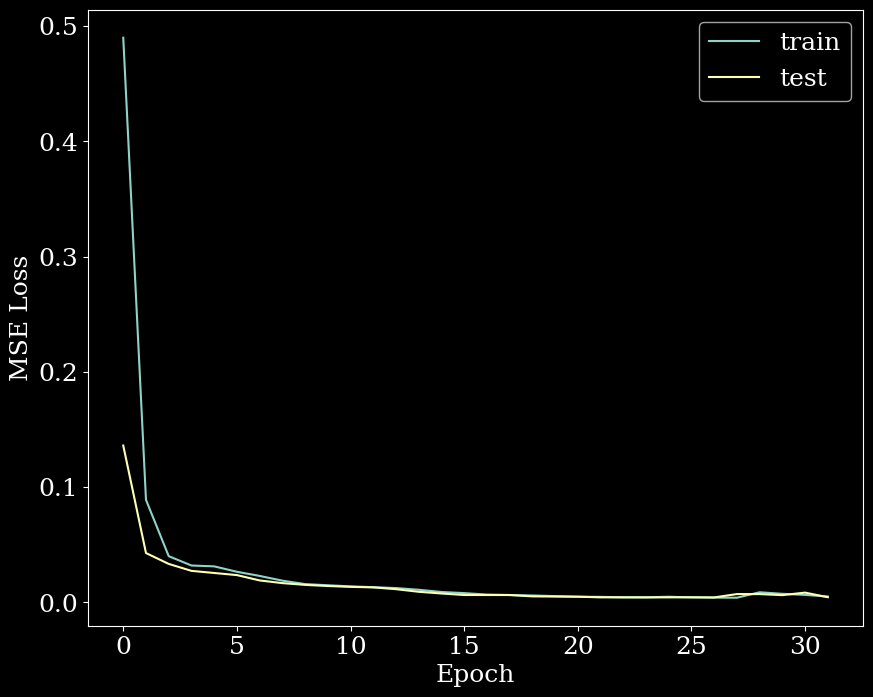

In [8]:
# plot the training and validation loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# Add legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

# ... aaaaand plot!
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


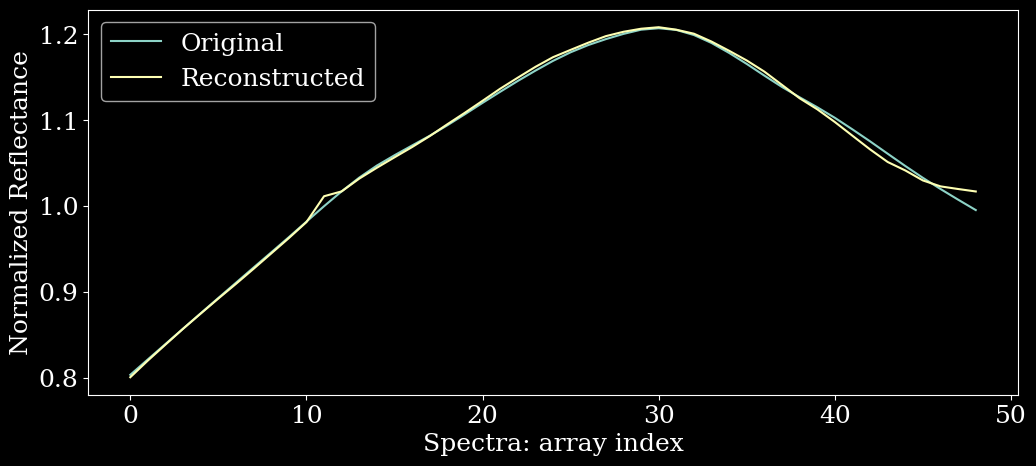

In [9]:
# Which index shall be displayed?
index_val = 100

# Original signal
org_signal = scaler.inverse_transform(X_train_scaled[index_val].reshape(1, -1))[0]
# Reconstructed signal
rec_signal = scaler.inverse_transform(model.predict(X_train_scaled)[index_val].reshape(1, -1))[0]

# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(org_signal, label='Original')
plt.plot(rec_signal, label='Reconstructed')

# Add legend and labels
plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")

# ... aaaaand plot!
plt.show()

In [10]:
# Create dataframe that contains the encoder values and the corresponding class to see whether the
# autoencoder values cluster in a way

# Encode the spectra
X_train_encoded = encoder_model.predict(X_train_scaled)
X_test_encoded = encoder_model.predict(X_test_scaled)

# Merge the data
X_encoded = np.vstack((X_train_encoded, X_test_encoded))

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the encoded data to fit
# the scaler
enc_scaler = preprocessing.StandardScaler().fit(X_encoded)

# Transform now the encoded data (later used for our scikit-learn method)
X_encoded_scaled = enc_scaler.transform(X_encoded)

# Merge the classes
y_main = np.hstack((y_train, y_test))
y_bus = np.hstack((y_train_bus, y_test_bus))

# Create a column names array for the encoded space
encoder_space = [f"enc{enc_nr+1}" for enc_nr in range(n_bottleneck)]
encoder_space_cols = encoder_space.copy()
encoder_space.extend(["Main_Group", "Bus_Class"])

# Create the dataframe
encoded_df = pd.DataFrame(np.hstack((X_encoded_scaled,
                                     y_main[np.newaxis].transpose(),
                                     y_bus[np.newaxis].transpose())),
                          columns=encoder_space)

# Change the dtype to float
encoded_df.loc[:, encoder_space[:-2]] = encoded_df.loc[:, encoder_space[:-2]].astype(float)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [11]:
import hdbscan
import tqdm

# Result dataframe: cluster size, number of clusters, noise ratio, model
hdbscan_results_df = pd.DataFrame(
    [], columns=["Min_Cluster_Size", "Nr_Clusters", "Noise_Ratio", "Model"]
)

min_cluster_sizes = np.arange(5, 51, 5)

for index, mcs in tqdm.tqdm(enumerate(min_cluster_sizes)):

    temp_clusterer = hdbscan.HDBSCAN(
        min_cluster_size=mcs,
        min_samples=None,
        metric="euclidean"
    )

    labels = temp_clusterer.fit_predict(X_encoded_scaled)

    nr_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_ratio = np.sum(labels == -1) / len(labels)

    hdbscan_results_df.loc[index] = [
        mcs,
        nr_clusters,
        noise_ratio,
        temp_clusterer
    ]


10it [00:00, 26.81it/s]


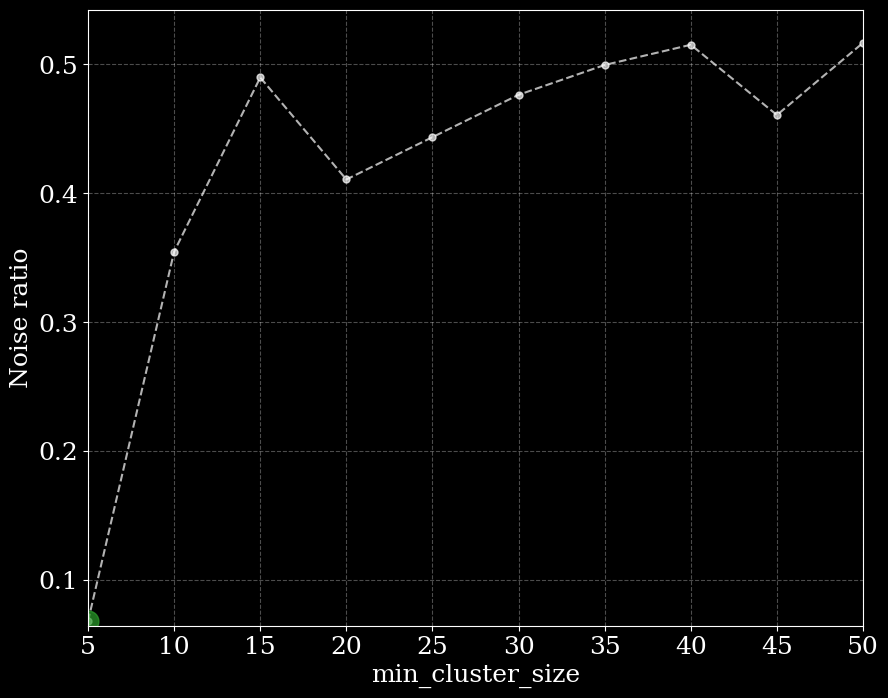

In [12]:
# Matplotlib settings (MATCH GMM)
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

plt.figure(figsize=(10, 8))

# Main curve (white dashed + markers)
plt.plot(
    hdbscan_results_df["Min_Cluster_Size"],
    hdbscan_results_df["Noise_Ratio"],
    linestyle="dashed",
    marker="o",
    markersize=5,
    color="w",
    alpha=0.7
)

# Highlight "best" point (green dot)
best_idx = hdbscan_results_df["Noise_Ratio"].idxmin()

plt.plot(
    hdbscan_results_df.loc[best_idx, "Min_Cluster_Size"],
    hdbscan_results_df.loc[best_idx, "Noise_Ratio"],
    marker="o",
    markersize=15,
    color="tab:green",
    alpha=0.7
)

# Labels
plt.xlabel("min_cluster_size")
plt.ylabel("Noise ratio")

# Grid (same as GMM)
plt.grid(linestyle="dashed", alpha=0.3)

# Axis limits (VERY important for similar look)
plt.xlim(
    hdbscan_results_df["Min_Cluster_Size"].min(),
    hdbscan_results_df["Min_Cluster_Size"].max()
)

plt.ylim(
    hdbscan_results_df["Noise_Ratio"].min() * 0.95,
    hdbscan_results_df["Noise_Ratio"].max() * 1.05
)

plt.show()


In [13]:
best_row = hdbscan_results_df.loc[
    (hdbscan_results_df["Nr_Clusters"] >= 2)
].sort_values("Noise_Ratio").iloc[0]

best_hdbscan = best_row["Model"]


In [14]:
encoded_df.loc[:, "HDBSCAN_Class"] = best_hdbscan.labels_
encoded_df


,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,HDBSCAN_Class
0,0.610832,-0.571561,1.183338,-1.435221,0.081261,S,S,1
1,-1.261198,0.908302,-1.022165,1.394942,-0.060793,C,Ch,1
2,0.250838,1.336683,0.559552,-0.646585,1.75888,Other,T,1
3,-1.239699,1.568132,-1.562441,0.779463,-0.81195,C,B,1
4,0.45673,-0.929921,1.051082,-1.188415,-0.814121,S,S,1
...,...,...,...,...,...,...,...,...
1334,-1.183551,0.523833,-1.769774,1.575468,-0.707366,C,Ch,1
1335,0.652753,1.674423,0.899905,-1.703656,2.154266,Other,D,-1
1336,-0.893682,1.037175,-1.10294,0.937169,0.04631,C,C,1
1337,-0.15349,0.351744,-0.068134,-0.241545,0.464792,X,Xe,1


In [15]:
encoded_grouped_df = pd.crosstab(
    index=encoded_df["Main_Group"],
    columns=encoded_df["HDBSCAN_Class"],
    values=encoded_df["enc1"],
    aggfunc="count"
)

encoded_grouped_values = encoded_grouped_df.values
encoded_grouped_main = encoded_grouped_df.index.values
encoded_grouped_clusters = [f"C{k}" for k in encoded_grouped_df.columns.values]


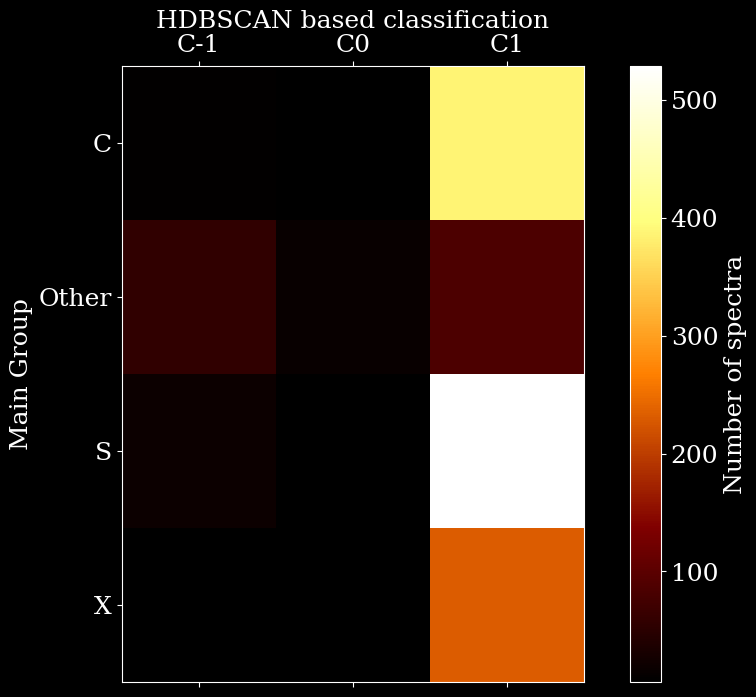

In [16]:
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(encoded_grouped_values, cmap="afmhot")
fig.colorbar(cax, label="Number of spectra", fraction=0.05)

ax.set_xticks(range(len(encoded_grouped_clusters)))
ax.set_yticks(range(len(encoded_grouped_main)))
ax.set_xticklabels(encoded_grouped_clusters)
ax.set_yticklabels(encoded_grouped_main)

ax.set_xlabel("HDBSCAN based classification")
ax.set_ylabel("Main Group")
ax.xaxis.set_label_position('top')


In [17]:
encoded_main_s_df = encoded_df.loc[
    encoded_df["Main_Group"] == "S"
].copy()

encoded_main_s_df.groupby("HDBSCAN_Class").count()


,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class
HDBSCAN_Class,,,,,,,
-1,20,20,20,20,20,20,20
1,529,529,529,529,529,529,529


In [18]:
encoded_main_s_df.loc[:, "Cluster_Strength"] = \
    best_hdbscan.probabilities_[encoded_main_s_df.index]

encoded_main_s_df


,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,HDBSCAN_Class,Cluster_Strength
0,0.610832,-0.571561,1.183338,-1.435221,0.081261,S,S,1,0.843331
4,0.45673,-0.929921,1.051082,-1.188415,-0.814121,S,S,1,0.645243
5,0.33897,-1.105379,0.414039,-0.457284,-0.19803,S,S,1,1.000000
8,0.291862,-0.250709,0.582352,-0.434758,-0.158258,S,S,1,1.000000
10,-0.028206,-0.376647,-0.078134,-0.021419,-0.901035,S,Sq,1,1.000000
...,...,...,...,...,...,...,...,...,...
1320,1.078312,-0.811737,1.502064,-1.511376,0.553747,S,Sl,1,0.841593
1322,1.362953,-1.580431,0.962631,-0.939806,-0.317598,S,S,1,0.783550
1324,0.414733,-0.433642,1.260804,-0.659849,-0.118397,S,S,1,0.962141
1333,0.870718,-0.539748,1.242468,-0.955865,0.414842,S,S,1,1.000000


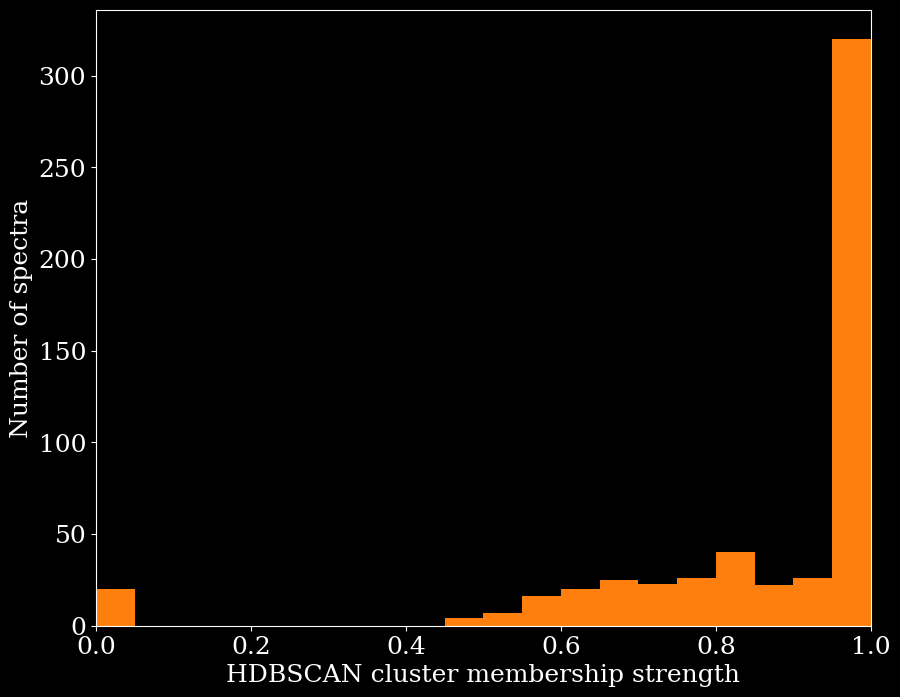

In [19]:
plt.figure(figsize=(10, 8))
plt.hist(encoded_main_s_df["Cluster_Strength"],
         bins=np.arange(0, 1.05, 0.05),
         color="tab:orange")

plt.xlim(0, 1)
plt.xlabel("HDBSCAN cluster membership strength")
plt.ylabel("Number of spectra")
plt.show()


In [20]:
encoded_main_s_df = encoded_main_s_df.loc[
    encoded_main_s_df["Cluster_Strength"] >= 0.95
]


In [21]:
import pingouin

encoded_main_s = np.array(
    encoded_main_s_df[encoder_space_cols].values,
    dtype="float64"
)

pingouin.multivariate_normality(encoded_main_s)


HZResults(hz=np.float64(1.1819969179001921), pval=np.float64(4.575057991720337e-05), normal=False)